In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchtext.legacy.data import LabelField, Field, BucketIterator, TabularDataset, Pipeline

import spacy
import numpy as np
import pandas as pd

import random
import math
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Sentence polarity dataset: Yelp, amazon

Loading IMDB data

In [ ]:
Data = pd.read_csv("../IMDB Dataset.csv")
Data.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
Data['review'] = Data['review'].apply(lambda x: ' . '.join(x.lower().split('<br /><br />'))).apply(lambda x: ' '.join(x.split()[:25]))
Data['sentiment'] = Data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
# Negative['review'] = Negative['review'].apply(lambda x: ' . '.join(x.lower().split('<br /><br />'))).apply(lambda x: ' '.join(x.split()[:25]))

In [ ]:
Data = Data.sample(frac=1)

In [ ]:
Data.head()

,review,sentiment
20308,although this film was made before dogme emerg...,0
37706,my grandmother took me and my sister out to se...,0
6041,possibly the worst film within the genre in ex...,0
42143,as long as you keep in mind that the productio...,0
23202,the plot in petites coupures certainly left th...,0


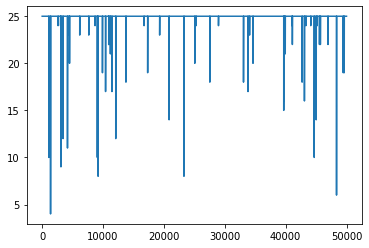

In [ ]:
plt.plot([len(x.split()) for x in Data['review']])

In [ ]:
# Positive_train = Positive['review'][:24000]
# Positive_test = Positive['review'][-1000:]

# Negative_train = Negative['review'][:5000]
# Negative_test = Negative['review'][-1000:]
# len(Positive_train),len(Positive_test),len(Negative_train),len(Negative_test)
Train = Data.iloc[:5000,:]
Test = Data.iloc[5000:6000,:]
Train.head()

,review,sentiment
20308,although this film was made before dogme emerg...,0
37706,my grandmother took me and my sister out to se...,0
6041,possibly the worst film within the genre in ex...,0
42143,as long as you keep in mind that the productio...,0
23202,the plot in petites coupures certainly left th...,0


In [ ]:
Train.to_csv('/content/train.csv',index=False)
Test.to_csv('/content/test.csv',index=False)

# Negative_train.to_csv('/content/Negative_train.csv',index=False)
# Negative_test.to_csv('/content/Negative_test.csv',index=False)

In [ ]:
# Positive = Data[Data['sentiment'] == 1]
# Negative = Data[Data['sentiment'] == 0]
# Negative.head()

Loading of Amazon Data

In [ ]:
# Positive = pd.read_csv("/content/amazon_pos_data.csv")
# Negative = pd.read_csv("/content/amazon_neg_data.csv")

In [ ]:
# len(Positive), len(Negative)

In [ ]:
# Positive_train = Positive[:5000]
# Positive_test = Positive.iloc[-1000:,:]

# Negative_train = Negative[:5000]
# Negative_test = Negative.iloc[-1000:,:]
# len(Positive_train),len(Positive_test),len(Negative_train),len(Negative_test)

In [ ]:
# Positive_train.to_csv('/content/Positive_train.csv',index=False)
# Positive_test.to_csv('/content/Positive_test.csv',index=False)

# Negative_train.to_csv('/content/Negative_train.csv',index=False)
# Negative_test.to_csv('/content/Negative_test.csv',index=False)

In [ ]:
# Positive_train.head()

In [ ]:
# pos_train = Positive_train['review'].tolist()
# pos_test  = Positive_test['review'].tolist()
# neg_train = Negative_train['review'].tolist()
# neg_test  = Negative_test['review'].tolist()

# Train_data = pd.DataFrame({"review": pos_train+neg_train, "label": [1]*len(pos_train)+ [0]*len(neg_train)})
# Test_data = pd.DataFrame({"review": pos_test+neg_test, "label": [1]*len(pos_test)+ [0]*len(neg_test)})

# Train_data = Train_data.sample(frac=1)

# Train_data.head()

In [ ]:
# Train_data.to_csv("/content/train.csv", index = False)
# Test_data.to_csv("/content/test.csv", index = False)

**MODEL**

In [ ]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer(text):
  # return text.split()
  return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
REVIEW = Field(sequential=True,
              tokenize = 'spacy', #tokenizer,
              use_vocab = True, 
              init_token = '<sos>', 
              eos_token = '<eos>', 
              batch_first = True,
              lower = True)

LABEL = Field(sequential=False, dtype=torch.double, batch_first=True, use_vocab=False, preprocessing=Pipeline(lambda x: float(x)))

fields = [('review', REVIEW),('label',LABEL)] # ('token_type', TTYPE), ('start',START), ('end',END)]

In [ ]:
train_data, test_data = TabularDataset.splits(
                                        path = '/content/',
                                        train = 'train.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)

print(type(train_data))

<class 'torchtext.legacy.data.dataset.TabularDataset'>


In [ ]:
from torchtext.vocab import FastText
import os
# embedding_glove = GloVe(name='6B', dim=100)

cache = '../vector_cache'
if not os.path.exists(cache):
    os.mkdir(cache)
vectors = FastText(language='en', cache=cache)

In [ ]:
REVIEW.build_vocab(train_data, test_data, vectors = vectors, min_freq = 1) # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'>
LABEL.build_vocab(train_data)
# ORIGINAL.build_vocab(train_data,test_data)  # train_data must be of type <class 'torchtext.legacy.data.dataset.TabularDataset'

In [ ]:
# LABEL.vocab.itos[2]

In [ ]:
for itr in train_data:
  print(itr.review, itr.label)
  break

['although', 'this', 'film', 'was', 'made', 'before', 'dogme', 'emerged', 'as', 'the', 'predominant', 'method', 'of', 'filmmaking', ',', 'and', 'before', 'digital', 'triumphed', 'over', '--', 'strike', 'that', '.', 'you', 'get', 'the'] 0.0


In [ ]:
print(len(REVIEW.vocab))
print(REVIEW.vocab.stoi['<eos>'] , REVIEW.vocab.stoi['<sos>'], REVIEW.vocab.stoi['<pad>'] , REVIEW.vocab.stoi['<unk>'])
print(train_data[0].__dict__.keys())
print(train_data[20].__dict__.values())

14142
3 2 1 0
dict_keys(['review', 'label'])
dict_values([['it', "'s", 'rare', 'that', 'i', 'come', 'across', 'a', 'film', 'this', 'awful', ',', 'this', 'annoying', 'and', 'this', 'irritating', '.', 'it', 'is', 'without', 'doubt', 'one', 'of', 'the', 'worst', 'films', 'i', "'ve"], 0.0])


In [ ]:
BATCH_SIZE = 128

train_iterator, test_iterator = BucketIterator.splits(
                                                      (train_data, test_data), 
                                                      batch_size = BATCH_SIZE,
                                                      sort_key = lambda x : len(x.review),
                                                      shuffle = False,
                                                      device = device
                                                    )

In [ ]:
device

device(type='cuda')

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, latent_dim, device):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, num_layers = 2, bidirectional = True, dropout = 0.25)
        
        self.w_mu = nn.Linear(enc_hid_dim*2, latent_dim, device=device)
        self.w_logvar = nn.Linear(enc_hid_dim*2, latent_dim, device=device)

        self.N = torch.distributions.Normal(0, 1)

        # if device == 'cuda':
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)

        self.dropout = nn.Dropout(dropout)
        self.device = device
        # self.fc = nn.Linear(2*enc_hid_dim, dec_hid_dim)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)

        #outputs = [src len, batch size, enc hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        h = torch.cat(((hidden[-1,:,:]+hidden[-2,:,:])/2, (hidden[-3,:,:]+hidden[-4,:,:])/2), dim = -1)

        #h = [batch size, encoder hidden dim * 2]

        mu, logvar = self.w_mu(h), self.w_logvar(h)
        
        #outputs = [src len, batch size, enc hid dim*2]

        #mu , logvar = [batch sz, latent dim], [batch size, latent dim]
        z = mu + torch.exp(0.5*logvar) * self.N.sample(mu.shape)
        
        return h, mu, logvar, z

In [ ]:
class Generator(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, encoder):
        super(Generator, self).__init__()

        self.output_dim = output_dim
        
        # self.embedding = nn.Embedding(output_dim,emb_dim)
        self.embedding = encoder.embedding
        
        self.rnn = nn.GRU(emb_dim, dec_hid_dim, dropout = 0.30)
        
        self.fc_out = nn.Linear( dec_hid_dim , output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input.long()))
        
        #embedded = [1, batch size, emb dim]
            
        output, hidden = self.rnn(embedded, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        assert (output == hidden).all()
        
        output = output.squeeze(0)
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [ ]:
# class Discriminator(nn.Module):

#   def __init__(self, REVIEW):
#     super(Discriminator, self).__init__()   
#     self.fc = nn.Linear(len(REVIEW.vocab), 1)
#     self.activation = nn.Sigmoid()

#   def forward(self, X):
#     # X = [batch size, seq_len, vocab size]
#     batch_size = X.shape[0]
#     vocab_size = X.shape[-1]

#     X = torch.sum(X,dim=1) # [batch size , vocab size]

#     return self.activation(self.fc(X)).view(batch_size, 1)

    


In [ ]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, device, latent_dim, dec_hid_dim):
        super(VAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.latent_dim = latent_dim
        self.dec_hid_dim = dec_hid_dim
        self.teacher_forcing_ratio = 0.50
        
    def forward(self, src, trg, label, temperature = 1):
        
        src = src.permute(1,0) #src = [src len, batch size]
        trg = trg.permute(1,0) #trg = [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        _, mu, logvar, z  = self.encoder(src) # mu = [batch sz ,enc hid dim]

        scale = 0 #label.unsqueeze(-1).expand(mu.shape)

        self.kl = 0.5*(mu**2 + torch.exp(logvar) - 1 - logvar).sum()/batch_size        # avg kl loss across batch

        input = trg[0,:]
        
        # print(z.shape) #[batch size]
        hidden = torch.cat((z,label.unsqueeze(1)),dim=1).float() # [ batch size, latent dim + 1] and (latent dim + 1 == decoder hid dim)
        
        for t in range(1, trg_len):
            
            output, hidden = self.decoder(input, hidden)
            
            outputs[t] = (output / temperature)
            teacher_force = random.random() < self.teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else torch.zeros(top1.shape).to(device) # force <unk> token 25% of the times

        return outputs

In [ ]:
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 50
DEC_HID_DIM = ENC_HID_DIM+1 # extra 1 owing the number of discriminators used
LATENT_DIM = ENC_HID_DIM
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

In [ ]:
def initialize_model(REVIEW,device):
  INPUT_DIM = len(REVIEW.vocab)
  OUTPUT_DIM = len(REVIEW.vocab)
  global ENC_EMB_DIM
  global DEC_EMB_DIM
  global ENC_HID_DIM
  global DEC_HID_DIM
  global LATENT_DIM
  global ENC_DROPOUT
  global DEC_DROPOUT

  enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, LATENT_DIM, device).to(device)
  enc.embedding.weight.data.copy_(REVIEW.vocab.vectors)
  enc.embedding.weight.requires_grad = True

  generator = Generator(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, enc).to(device)

  vae = VAE(enc, generator, device, LATENT_DIM, DEC_HID_DIM).to(device)
  
  return vae, enc, generator

In [ ]:
vae, enc, generator = initialize_model(REVIEW,device)
# discriminator = Discriminator(REVIEW).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         if 'weight' in name:
#             nn.init.normal_(param.data, mean=0, std=0.01)
#         else:
#             nn.init.constant_(param.data, 0)  #  initialise bias with 0
            
# vae.apply(init_weights)
# discriminator.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(vae)} trainable parameters')

The model has 5193293 trainable parameters


In [ ]:
optimizer = optim.Adam(vae.parameters(), lr = 0.001)

TRG_PAD_IDX = REVIEW.vocab.stoi[REVIEW.pad_token]

criterion1 = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX).to(device)
# criterion2 = nn.BCELoss().to(device)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train_vae(model, iterator, optimizer, criterion, clip, temperature = 1):
    
    global device
    global DEC_HID_DIM

    model.train()
    
    epoch_loss = 0
    kl = 0
    
    for idx,batch in enumerate(iterator):
        
        src = batch.review.to(device) # [batch sz, seq len]
        trg = batch.review.to(device) #  [batch sz, seq len]
        label = batch.label.to(device) # [batch sz]
        # print(src.shape, trg.shape, label.shape)
        
        optimizer.zero_grad()
        
        output = model(src, trg, label, temperature)
        # print(output.shape)
        
        trg = trg.permute(1,0) #trg = [trg len , batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg.contiguous()
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg) + 100*model.kl  # bata-VAE, beta value can be set to cyclic/linear annealing, but showed no improvement over the current value
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        kl += model.kl.item()
        
    # print(f"Shape of latent dict : {model.latent_dict.shape}")
    return epoch_loss / len(iterator), kl/len(iterator)

In [ ]:
def test_vae(model, iterator, criterion, temperature=1):
    
    global device

    model.eval()
    
    epoch_loss = 0
    tot = 0
    
    with torch.no_grad():
    
      for batch in iterator:
          
        src = batch.review.to(device)
        trg = batch.review.to(device)
        label = batch.label.to(device)
              
        output = model(src, trg, label, temperature)
        
        trg = trg.permute(1,0) #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output_tokens = torch.argmax(output[1:], dim=-1).view(-1)
        trg = trg.contiguous()
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg) + 100*model.kl
        
        epoch_loss += loss.item()
        tot += (output_tokens == trg).sum().item()
        
    return epoch_loss / len(iterator), tot/len(iterator)

Train the base VAE model

In [ ]:
N_EPOCHS = 30
CLIP = 1

best_val_loss = float('inf')
ptl = []
pvl = []
pkl = []


for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_kl = train_vae(vae, train_iterator, optimizer, criterion1, CLIP)

    # valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    val_loss, validation_EM_score = test_vae(vae, test_iterator, criterion1)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vae.state_dict(), '../vae_imdb.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Validation_loss : {val_loss:.4f} | Validation EM score : {validation_EM_score}')
    ptl.append(train_loss)
    pvl.append(val_loss)
    pkl.append(train_kl)

Epoch: 01 | Time: 0m 14s
	Train Loss: 11.4086 | Validation_loss : 8.0591 | Validation EM score : 71.875
Epoch: 02 | Time: 0m 13s
	Train Loss: 7.0123 | Validation_loss : 6.8049 | Validation EM score : 154.375
Epoch: 03 | Time: 0m 13s
	Train Loss: 6.5629 | Validation_loss : 6.6833 | Validation EM score : 156.75
Epoch: 04 | Time: 0m 13s
	Train Loss: 6.4861 | Validation_loss : 6.6413 | Validation EM score : 159.125
Epoch: 05 | Time: 0m 13s
	Train Loss: 6.4536 | Validation_loss : 6.6286 | Validation EM score : 159.625
Epoch: 06 | Time: 0m 13s
	Train Loss: 6.4365 | Validation_loss : 6.6299 | Validation EM score : 159.75
Epoch: 07 | Time: 0m 16s
	Train Loss: 6.4210 | Validation_loss : 6.6096 | Validation EM score : 170.875
Epoch: 08 | Time: 0m 15s
	Train Loss: 6.3962 | Validation_loss : 6.5834 | Validation EM score : 189.5
Epoch: 09 | Time: 0m 15s
	Train Loss: 6.3609 | Validation_loss : 6.5454 | Validation EM score : 214.625
Epoch: 10 | Time: 0m 13s
	Train Loss: 6.3216 | Validation_loss : 6.5

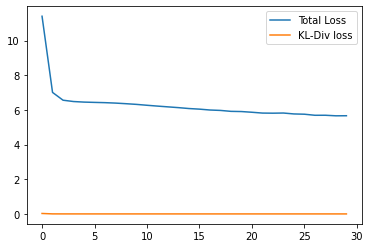

In [ ]:
plt.plot(ptl,label='Total Loss')
plt.plot(pkl,label='KL-Div loss')
plt.legend()
plt.show()

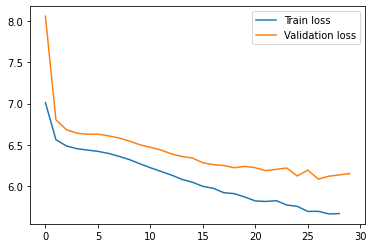

In [ ]:
plt.plot(ptl[1:],label = 'Train loss')
plt.plot(pvl,label='Validation loss')
plt.legend()
plt.show()

In [ ]:
def load_model(PATH,enc,generator,device):
  model = VAE(enc, generator, device, LATENT_DIM, DEC_HID_DIM).to(device)
  model.load_state_dict(torch.load(PATH,map_location=device))
  print("All keys matched successfully!")
  return model

In [ ]:
PATH = "../vae_imdb.pt"
vae = load_model(PATH,enc,generator,device)

All keys matched successfully!


**Inference**

In [ ]:
def inference(model,sentiment):
    
  global device

  scale = 0
  N = torch.distributions.MultivariateNormal(torch.zeros(LATENT_DIM).to(device)+scale,torch.diag(torch.ones(LATENT_DIM).to(device)))
  z = N.sample().unsqueeze(0)
  # print(z.shape)

  if sentiment == "pos":
    c = torch.ones(1,1).to(device)
  else:
    c = torch.zeros(1,1).to(device)

  hidden = torch.cat((z,c),dim=1) # [1, dec hid dim + 1]
  # print(hidden.shape)
  
  input = torch.tensor([2]).to(device)
  top1 = -1
  sentence = []

  while top1 != 3:

    output, hidden = model.decoder(input, hidden)

    top1 = output.argmax(1).item()

    if top1 != 3 and top1 != -1:
      sentence.append(top1)

    input = torch.tensor([top1]).to(device)

    if len(sentence) > 25:
      break

  return sentence

In [ ]:
new_pos = []
for i in range(100):
  temp = inference(vae, "pos")
  new_pos.append(' '.join([REVIEW.vocab.itos[x] for x in temp]) + ' \n')


new_neg = []
for i in range(100):
  temp = inference(vae, "neg")
  new_neg.append(' '.join([REVIEW.vocab.itos[x] for x in temp])+ ' \n')


In [ ]:
with open('/content/pos.txt','w') as f:
  f.writelines(new_pos)


with open('/content/neg.txt','w') as f:
  f.writelines(new_neg)

If running o google colab, restart the system here, else will show CUDA out of memory **OR** use trg.reshape in the above functions instead of trg.view

In [ ]:
new_pos = []
new_neg = []

with open('/content/pos.txt','r') as f:
  new_pos = f.read().split('\n')


with open('/content/neg.txt','r') as f:
  new_neg = f.read().split('\n')


In [ ]:
pos_num = len(new_pos)
neg_num = len(new_neg)

In [ ]:
import tensorflow_hub as hub

# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Data_vecs = embed(new_pos).numpy().tolist() + embed(new_neg).numpy().tolist()

Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 202 samples in 0.000s...
[t-SNE] Computed neighbors for 202 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 202 / 202
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.230045
[t-SNE] KL divergence after 1000 iterations: 0.178219


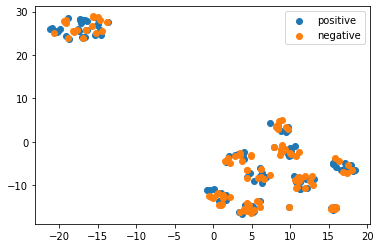

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, verbose = True)
transformed_data = tsne.fit_transform(Data_vecs)

plt.scatter(transformed_data[:pos_num,0],transformed_data[:pos_num:,1], label = "positive")
plt.scatter(transformed_data[pos_num:,0],transformed_data[pos_num:,1], label = "negative")
plt.legend()
plt.show()

In [ ]:
new_pos

['i was a movie . i was a movie . i was a good movie . i was a ',
 'i was a movie . i was a movie . i was a good movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a good movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a good movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a good movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a good , but i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a good movie . i 

In [ ]:
new_neg

['i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a good movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a good movie . i was a ',
 'i was a movie . i was a movie . i was a good movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a movie . i was a movie . i was a movie . i was a ',
 'i was a